# Machine Learning for Cities group project: Understanding the impact of spatial variables in predicting travel mode choice

Team Members: Eren Kaval (ek3433@nyu.edu), Shicheng Jin (sj3697@nyu.edu), Vinita Wagh (vw2050@nyu.edu), Vittorio Costa (vc2280@nyu.edu), Yu Huang (yh3483@nyu.edu). 

## 0. Summary

This supervised learning analysis we try to predict the most preferred travel mode of a single person in New York City. First, we will test the performances of a benchmark model on features from Survey data aggregated at the personid level. Then, we will try to see whether by adding spatial variables (e.g., number of car registrations, number of metro stops) related to the (home) zip code has significant effects on model's performances. Also, since there are different type of modes, we have used appropriate models for multi-class classification. Lastly, we try to use SMOTE on the best predictive model to balance the label class.

This notebook is organized in the following way:

    1. Data Cleaning
        a. Survey Data
        b. Spatial Variables
            I. Bus, Subway and Citibike Data
            II. PLUTO Landuse Data
            III. Car + EV Registration
            IV. Merging Spatial Dataframes
        c. Merging with Spatial Variables
    2. Exploratory Analysis
        a. PersonId Level
        b. Zipcode Level
    3. Data Preprocessing
    4. Data Modelling (Classification)
        a. Benchmark
                I. Logistic Regression
                II. Naive Bayes
                III. Decision Tree
                IV. SVM
                V. Random Forest
        b. Added Spatial Variables
                I. Logistic Regression
                II. Naive Bayes
                III. Decision Tree
                IV. SVM
                V. Random Forest
        c. Handling Imbalanced Datasets
    5. Results Overview

**Important: If you want to run the notebook go to 3. Data Processing and read the file called "df_personid.csv" we included in the submission**

## 1. Data Cleaning

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from shapely.geometry import Point
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

### a. Survey Data

In [ ]:
# Original dataset: Survey data about linked trips 
# Each entry is a trip taken by the person in which all the modes of transportation are specified
df = pd.read_excel("/Users/vittoriocosta/Downloads/Linked.xlsx")
df.head()

,hhid,personid,tripid,hh_group,sample_group,daynum,tripnum,traveldate,traveldate_dow,orig_type,...,commute_subsidy_7,commute_subsidy_997,commute_subsidy_998,work_loc_postal_code,work_countyfp,work_puma10,work_bg,per_weight_wd_trips_rsadj,per_weight_sat_rsadj,per_weight_sun_rsadj
0,22,2201,22011001,rMove,Postcard,First day of travel period,1,2018-03-15,Thursday,Home,...,Not Selected,Not Selected,Not Selected,NaN,NaN,NaN,NaN,56.3912,NaN,NaN
1,22,2201,22011002,rMove,Postcard,First day of travel period,2,2018-03-15,Thursday,Work,...,Not Selected,Not Selected,Not Selected,NaN,NaN,NaN,NaN,66.4692,NaN,NaN
2,22,2201,22011003,rMove,Postcard,First day of travel period,3,2018-03-15,Thursday,Work,...,Not Selected,Not Selected,Not Selected,NaN,NaN,NaN,NaN,53.0902,NaN,NaN
3,22,2201,22011004,rMove,Postcard,First day of travel period,4,2018-03-15,Thursday,Home,...,Not Selected,Not Selected,Not Selected,NaN,NaN,NaN,NaN,66.4692,NaN,NaN
4,22,2201,22012001,rMove,Postcard,Second day of travel period,1,2018-03-16,Friday,Home,...,Not Selected,Not Selected,Not Selected,NaN,NaN,NaN,NaN,56.3912,NaN,NaN


In [ ]:
# Make the job count numerical
df["job_count"] = df["job_count"].replace([None,"1 job","2 jobs","3 jobs","4 jobs","5 or more jobs"],[0,1,2,3,4,5])

In [ ]:
# Make the number of the day of travel period numerical
df["daynum"] = df["daynum"].replace(["First day of travel period","Second day of travel period","Third day of travel period","Fourth day of travel period","Fifth day of travel period","Sixth day of travel period", "Seventh day of travel period"],[1,2,3,4,5,6,7])

In [ ]:
# Make household size numerical
df["hhsize"] = df["hhsize"].replace(["1 (I am the only person)","2 people","3 people","4 people","5 people","6 people",\
                                     "7 people","8 people","9 people","10 people or more"],[1,2,3,4,5,6,7,8,9,10])
df["hhsize"] = df["hhsize"].astype(int)

In [ ]:
# Make the vehicle count numerical 
df["vehicle_count"].astype(str)
df["vehicle_count"] = df["vehicle_count"].replace("0 (no vehicles)",0)
df["vehicle_count"] = df["vehicle_count"].replace("5 or more vehicles",5)
df["vehicle_count"] = df["vehicle_count"].astype(int)

In [ ]:
# Convert distance to miles
df["distance"] = df["distance"].fillna("0")
df["distance"] = df["distance"].astype(int)
df["distance"] = df["distance"] * 0.621371

In [ ]:
# Ordinal encoding by hand
df["is_student"] = df["student_status"]
df["is_student"].loc[df["student_status"] == "Not a student"] = 0
df["is_student"].loc[df["student_status"] != "Not a student"] = 1
df["has_license"] = df["license"]
df["has_license"].loc[df["license"] == "Yes (license or learner’s permit)"] = 1
df["has_license"].loc[df["license"] != "Yes (license or learner’s permit)"] = 0
df["hasunder18"] = df["numagebelow18"]
df["hasunder18"].loc[df["numagebelow18"]=="None"] = 0
df["hasunder18"].loc[df["numagebelow18"]!="None"] = 1
df["hasdisability"] = df["disability"]
df["hasdisability"].loc[df["disability"]=="Yes"] = 1
df["hasdisability"].loc[df["disability"]!="Yes"] = 0
df["hassmartphone"] = "smartphone_own"
df["hassmartphone"].loc[df["smartphone_own"]=="Yes"] = 1
df["hassmartphone"].loc[df["smartphone_own"]!="Yes"] = 0
df["isbornus"] = df["born_us"]
df["isbornus"].loc[df["born_us"]=="Yes"] = 1
df["isbornus"].loc[df["born_us"]!="Yes"] = 0

In [ ]:
# find the number of trip segments for each trip
df["mode1_bool"] = df["mode1"].notnull().astype(int)
df["mode2_bool"] = df["mode2"].notnull().astype(int)
df["mode3_bool"] = df["mode3"].notnull().astype(int)
df["mode4_bool"] = df["mode4"].notnull().astype(int)
df["mode5_bool"] = df["mode5"].notnull().astype(int)
df["mode6_bool"] = df["mode6"].notnull().astype(int)
df["mode7_bool"] = df["mode7"].notnull().astype(int)
df["mode8_bool"] = df["mode8"].notnull().astype(int)
df["mode9_bool"] = df["mode9"].notnull().astype(int)
df["mode10_bool"] = df["mode10"].notnull().astype(int)
df["num_trips"] = df["mode1_bool"] + df["mode2_bool"] + df["mode3_bool"] + df["mode4_bool"] + df["mode5_bool"] + df["mode6_bool"] + df["mode7_bool"] + df["mode8_bool"] + df["mode9_bool"] + df["mode10_bool"]

In [ ]:
# Manually encode ethnicities
df["ethnicity_american_alaska"] = df["ethnicity_1"]
df["ethnicity_american_alaska"].loc[df["ethnicity_1"]=="Selected"] = 1
df["ethnicity_american_alaska"].loc[df["ethnicity_1"]!="Selected"] = 0
df["ethnicity_asian"] = df["ethnicity_2"]
df["ethnicity_asian"].loc[df["ethnicity_2"]=="Selected"] = 1
df["ethnicity_asian"].loc[df["ethnicity_2"]!="Selected"] = 0
df["ethnicity_black"] = df["ethnicity_3"]
df["ethnicity_black"].loc[df["ethnicity_3"]=="Selected"] = 1
df["ethnicity_black"].loc[df["ethnicity_3"]!="Selected"] = 0
df["ethnicity_hawaii"] = df["ethnicity_4"]
df["ethnicity_hawaii"].loc[df["ethnicity_4"]=="Selected"] = 1
df["ethnicity_hawaii"].loc[df["ethnicity_4"]!="Selected"] = 0
df["ethnicity_white"] = df["ethnicity_5"]
df["ethnicity_white"].loc[df["ethnicity_5"]=="Selected"] = 1
df["ethnicity_white"].loc[df["ethnicity_5"]!="Selected"] = 0
df["ethnicity_other"] = df["ethnicity_997"]
df["ethnicity_other"].loc[df["ethnicity_997"]=="Selected"] = 1
df["ethnicity_other"].loc[df["ethnicity_997"]!="Selected"] = 0
df["ethnicity_noanswer"] = df["ethnicity_999"]
df["ethnicity_noanswer"].loc[df["ethnicity_999"]=="Selected"] = 1
df["ethnicity_noanswer"].loc[df["ethnicity_999"]!="Selected"] = 0

In [ ]:
# Make the household income numerical (taking the mean of the value specified by the original range)
df["hh_income"] = df["hh_income"].replace(['$300,000 or more', '$100,000 - $149,999', '$75,000 - $99,999',
                                                         '$16,000- $19,999', '$37,000 - $40,999', '$50,000 - $74,999',
                                                         '$200,000 - $299,999', '$150,000 - $199,999', '$20,000 - $24,999',
                                                         '$12,000 - $15,999', '$25,000 - $28,999', '$29,000 - $32,999',
                                                         '$41,000 - $49,999', '$33,000 - $36,999', 'Less than $12,000', '[]'], 
                                                        [300000, 125000, 87500, 18000, 38500, 62500, 250000, 175000, 225000, 14000, 27000, 31000, 43000, 35000, 12000, 0],)

In [ ]:
# Make the age numerical (taking the mean of the value specified by the original range)
df["age"] = df["age"].replace(['35-39 years', '18-24 years', '30-34 years', '25-29 years', 
                                             '16-17 years', '40-44 years', 'Under 5 years old', '50-54 years',
                                             '5-15 years', '45-49 years', '55-59 years', '60-64 years',
                                             '65-69 years', '70-74 years', '75-79 years', '85 or years older',
                                             '80-84 years'],
                                            [37.0, 21.0, 32.0, 27.0, 16.5, 42.0, 5.0, 52.0, 10.0, 47.0, 57.0, 62.0, 67.0, 72.0, 77.0, 85.0, 82.0],)

In [ ]:
# Find the mode distribution and the preferred mode of tranportation for each personid
curr_id = 0
df["preferred mode"] = "Walk/Bike"
list_modes = []
columns = ["mode1","mode2","mode3","mode4","mode5","mode6","mode7","mode8","mode9","mode10"]
start=0
for i in range(len(df)):
    # if the id changes enter this part of the code
    if df["personid"][i] != df["personid"].unique()[curr_id]:
        mode = max(set(list_modes), key=list_modes.count)
        df["preferred mode"][start:i] = mode
        num_trips = sum(df["num_trips"][start:i])
        curr_id += 1
        start=i
        list_modes = []
    for j in columns:
        if type(df[j].iloc[i]) == str:
            # append the mode of transportation for each segment to the list of modes (for that personid)
            list_modes.append(df[j].iloc[i])
            # add the mode of transportation to its category counter (for that personid)

In [ ]:
# Fill nans
df["orig_type"] = df["orig_type"].fillna("")
df["purpose"] = df["purpose"].fillna("")
df["education_level"] = df["education_level"].fillna("")
df["english_prof "] = df["english_prof"].fillna("")
df["job_type"] = df["job_type"].fillna("")
df["commute_freq"] = df["commute_freq"].fillna("")
df["telecommute_freq"] = df["telecommute_freq"].fillna("")
df["home_postal_code"] = df["home_postal_code"].fillna(0)
df["hh_income"] = df["hh_income"].fillna(df["hh_income"].median())

In [ ]:
# Aggregate by personid and create the dataframe for the first part of the analysis
df_personid = df.groupby(['personid']).agg({'hh_group':pd.Series.mode,'sample_group':pd.Series.mode,\
                                            'dest_type': lambda x: pd.Series.mode(x)[0], 'orig_type': lambda x: pd.Series.mode(x)[0],\
                                            'tour_purpose': lambda x: pd.Series.mode(x)[0], 'departure_hour': 'mean', 'orig_bg':'max',\
                                            'dest_bg':'max', 'distance': 'mean','vehicle_count':'max','hhsize':'max',\
                                            'res_duration': lambda x: pd.Series.mode(x)[0], 'home_bg': 'max', 'hh_income': 'max',\
                                            'gender': pd.Series.mode, 'age': 'max', 'job_count': 'max',\
                                            'education_level': pd.Series.mode, 'english_prof': pd.Series.mode,\
                                            "ethnicity_american_alaska": 'max', "ethnicity_asian": 'max',\
                                            "ethnicity_black": 'max', "ethnicity_hawaii": 'max',\
                                            "ethnicity_white": 'max', "ethnicity_other": 'max',\
                                            "ethnicity_noanswer": 'max', 'job_type': pd.Series.mode,\
                                            'hours_worked': pd.Series.mode, "commute_freq":  pd.Series.mode,\
                                            'telecommute_freq':  pd.Series.mode, 'work_bg': 'max',\
                                            'is_student': 'max', 'has_license': 'max','hasunder18': 'max',\
                                            'hassmartphone':'max', 'isbornus': 'max',\
                                            "num_trips":"sum", 'home_postal_code':'max', "preferred mode": pd.Series.mode})
df_personid.head()

,hh_group,sample_group,dest_type,orig_type,tour_purpose,departure_hour,orig_bg,dest_bg,distance,vehicle_count,...,telecommute_freq,work_bg,is_student,has_license,hasunder18,hassmartphone,isbornus,num_trips,home_postal_code,preferred mode
personid,,,,,,,,,,,,,,,,,,,,,
2201,rMove,Postcard,Home,Home,Work,13.315789,3.608100e+11,3.608100e+11,1.210038,0,...,Less than monthly,NaN,0,1,1,1,1,23,11101.0,Walk/Bike
2701,rMove,Postcard,Friend/Family member’s house,Home,Work,14.000000,3.608101e+11,3.608101e+11,8.284947,1,...,"When necessary (e.g., during severe weather)",3.606101e+11,0,1,0,1,1,8,11105.0,NYC Subway
3501,rSurvey,Postcard,Home,Home,Work,15.666667,3.606101e+11,3.606101e+11,3.935350,0,...,1-3 days per month,3.606101e+11,0,1,0,1,1,3,11225.0,NYC Subway
4101,rSurvey,Postcard,Home,Friend/Family member’s house,Missing,15.000000,3.606102e+11,3.608104e+11,9.941936,0,...,2-3 days a week,3.606101e+11,0,1,0,1,0,2,11369.0,NYC Subway
4401,rMove,Postcard,Work,Work,Work,13.736842,3.608102e+11,3.608102e+11,5.363413,1,...,Never,3.606101e+11,0,1,0,1,0,30,10475.0,NYC Subway


In [ ]:
print(df_personid.shape)

(20032, 39)


In [ ]:
df_personid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20032 entries, 2201 to 5608902
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   hh_group                   20032 non-null  object 
 1   sample_group               20032 non-null  object 
 2   dest_type                  20032 non-null  object 
 3   orig_type                  20032 non-null  object 
 4   tour_purpose               20032 non-null  object 
 5   departure_hour             20032 non-null  float64
 6   orig_bg                    19883 non-null  float64
 7   dest_bg                    19901 non-null  float64
 8   distance                   20032 non-null  float64
 9   vehicle_count              20032 non-null  int64  
 10  hhsize                     20032 non-null  int64  
 11  res_duration               20032 non-null  object 
 12  home_bg                    20032 non-null  int64  
 13  hh_income                  20032 non-null

In [ ]:
# drop columns (too many nans)
df_personid = df_personid.drop(columns=["work_bg"])

### b. Spatial Variables (zipcode level)

#### I. Bus, Subway and Citibike Data

In [ ]:
trans = pd.read_csv('transportation.csv', encoding = 'UTF-8')

In [ ]:
trans = trans[['ZIPCODE', 'bus', 'subway', 'citybike']]

In [ ]:
trans1 = trans.groupby(['ZIPCODE']).mean().reset_index()
trans1.head()

,ZIPCODE,bus,subway,citybike
0,83,57.00,6.00,13.00
1,10001,53.00,7.00,15.00
2,10002,81.00,5.00,24.00
3,10003,55.00,7.00,23.00
4,10004,3.25,0.75,8.75


#### II. PLUTO Landuse Data

In [ ]:
tax_lot = pd.read_csv('pluto_21v3.csv', encoding = 'UTF-8')

In [ ]:
# keeping only necessary columns
tax_lot = tax_lot[['borough', 'lot', 'ct2010', 'zipcode', 'landuse', 'lotarea']]

In [ ]:
# keep only certain landuse
landuse_code = [1.0, 2.0, 3.0, 4.0, 5.0]
tax_lot_land = tax_lot[tax_lot['landuse'].isin(landuse_code)]

### landuse
# 01 = One & Two Family Buildings
# 02 = Multi-Family Walk-Up Buildings
# 03 = Multi-Family Elevator Buildings
# 04 = Mixed Residential & Commercial Buildings
# 05 = Commercial & Office Buildings

# 07 = Transportation & Utility
# 10 = Parking Facilities
# 06 = Industrial & Manufacturing
# 08 = Public Facilities & Institutions
# 09 = Open Space & Outdoor Recreation
# 11 = Vacant Land

In [ ]:
# check for null values
tax_lot_land.isnull().sum()

borough      0
lot          0
ct2010     245
zipcode    247
landuse      0
lotarea    506
dtype: int64

In [ ]:
# remove entries with null values
tax_lot_filter = tax_lot_land.dropna()

In [ ]:
# replace landuse numbers with names
tax_lot_filter["landuse"] = tax_lot_filter["landuse"].replace([1.0, 2.0, 3.0, 4.0, 5.0], ['res', 'res', 'res', 'mixed', 'comm'])

In [ ]:
# groupby zipcode and landuse category
land = tax_lot_filter.groupby(['zipcode', 'landuse']).agg({'lotarea':'sum'}).reset_index()

In [ ]:
# pivot to get landuse categories as columns
land_pivot = pd.pivot_table(land, index=['zipcode'], columns='landuse', values='lotarea', fill_value = 0).reset_index()

In [ ]:
# remove zipcodes outside of NYC
land_fil = land_pivot[(land_pivot['zipcode'] >= 10001) & (land_pivot['zipcode'] <= 11697)]

In [ ]:
# read zipcode area file so that landuse can be normalized
zips = gpd.read_file('ZIP_CODE_040114.shp')
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips_sel = zips[['ZIPCODE', 'POPULATION', 'AREA']]

In [ ]:
# merge zipcode area and landuse files
zips_land = zips_sel.merge(land_fil, left_on = 'ZIPCODE', right_on = 'zipcode', how = 'left')

In [ ]:
# normalize landuse columns with zipcode areas
zips_land['comm_percent'] = zips_land['comm'] / zips_land['AREA']
zips_land['mixed_percent'] = zips_land['mixed'] / zips_land['AREA']
zips_land['res_percent'] = zips_land['res'] / zips_land['AREA']

In [ ]:
# keep only necessary columns
landuse = zips_land[['ZIPCODE', 'comm_percent', 'mixed_percent', 'res_percent']]

In [ ]:
# aggregate by zipcode
landuse1 = landuse.groupby(['ZIPCODE']).agg({'comm_percent':'sum', 'mixed_percent':'sum', 'res_percent':'sum'}).reset_index()
landuse1.head()

,ZIPCODE,comm_percent,mixed_percent,res_percent
0,83,0.000000,0.000000,0.000000
1,10001,0.243263,0.087850,0.105132
2,10002,0.028694,0.144407,0.202177
3,10003,0.099431,0.176313,0.189146
4,10004,3.496761,0.936524,0.040107


#### III. Car + EV Registration

In [ ]:
data_CO = pd.read_csv('Vehicle__Snowmobile__and_Boat_Registrations.csv')

In [ ]:
# keep only selected vehicles and counties
bodytype_list= ['CONV','SEDN','4DSD','2DSD ','SUBN','MCY', 'FLAT','PICK','LIM','TAXI','MOPD','AMBU'] #filtering the private vehicles only for further analysis (cars only)
data_CO = data_CO[data_CO['Body Type'].isin(bodytype_list)]
county_list = ['NEW YORK', 'BRONX', 'KINGS', 'QUEENS', 'RICHMOND']
data_CO = data_CO[data_CO['County'].isin(county_list)]

In [ ]:
# converting registration and expiry date columns to datetime types
data_CO['Reg Valid Date'] = pd.to_datetime(data_CO['Reg Valid Date']) 
data_CO['Reg Expiration Date'] = pd.to_datetime(data_CO['Reg Expiration Date'])

In [ ]:
# extracting registration month and year
data_CO['Month'] = data_CO['Reg Valid Date'].dt.month
data_CO['Year'] = data_CO['Reg Valid Date'].dt.year

In [ ]:
# filtering by registration years
data_CO = data_CO[data_CO['Year'] >=2014]
data_CO = data_CO[data_CO['Year'] < 2019]

In [ ]:
# removes zipcodes outside NYC
data_zip = data_CO[(data_CO['Zip'] >= 10001) & (data_CO['Zip'] <= 11697)]

In [ ]:
# keep only selected columns
data_sel = data_zip[['Zip', 'Year']]

In [ ]:
# aggregate regigstrations by zipcode
data_grp = data_sel.groupby(['Zip']).agg({'Year':'count'}).reset_index()
data_grp.rename(columns = {'Year':'Reg_count'}, inplace = True)
data_grp.head()

,Zip,Reg_count
0,10001,12
1,10002,4
2,10003,429
3,10004,281
4,10006,33


In [ ]:
ev_reg = pd.read_csv('EV-Registration-Tables.csv', encoding = 'UTF-8')

In [ ]:
# keep only selected columns
ev_reg = ev_reg[['ZIP Code', 'Registration Valid Date']]

In [ ]:
# converting registration and expiry date columns to datetime types
ev_reg['Registration Valid Date'] = pd.to_datetime(ev_reg['Registration Valid Date']) 

In [ ]:
# extracting registration month and year
ev_reg['EV Reg Month'] = ev_reg['Registration Valid Date'].dt.month
ev_reg['EV Reg Year'] = ev_reg['Registration Valid Date'].dt.year

In [ ]:
# keeping only NYC zipcodes
ev_reg_zip = ev_reg[(ev_reg['ZIP Code'] >= 10001) & (ev_reg['ZIP Code'] <= 11697)]
ev_reg_zip = ev_reg_zip.reset_index(drop = True)

In [ ]:
# keeping registrations before 2019
ev_reg_year = ev_reg_zip[(ev_reg_zip['EV Reg Year'] < 2019)].reset_index(drop = True)

In [ ]:
# aggregate registrations by zipcode
ev_reg_zip = ev_reg_year.groupby(['ZIP Code']).agg({'EV Reg Year':'count'}).reset_index()
ev_reg_zip.rename(columns = {'EV Reg Year':'Reg_count'}, inplace = True)
ev_reg_zip.head()

,ZIP Code,Reg_count
0,10001,1467
1,10002,865
2,10003,2089
3,10004,2263
4,10005,317


In [ ]:
# merging car and ev dfs
car_ev = data_grp.merge(ev_reg_zip, left_on = 'Zip', right_on = 'ZIP Code', how = 'outer')
car_ev.rename(columns = {'Reg_count_x':'car_count', 'Reg_count_y':'ev_count'}, inplace = True)
car_ev = car_ev[['ZIP Code', 'car_count', 'ev_count']]
car_ev['total_car_ev_count'] = car_ev['car_count'] + car_ev['ev_count']
car_ev = car_ev.fillna(0)

In [ ]:
# merge with zipcode area file for normalization
zip_evcar = zips_sel.merge(car_ev, left_on = 'ZIPCODE', right_on = 'ZIP Code', how = 'left')
zip_evcar_sel = zip_evcar[['ZIPCODE', 'total_car_ev_count', 'POPULATION']]
zip_evcar_sel = zip_evcar_sel.fillna(0)

In [ ]:
# normalize ev and car count by population
zip_evcar_sel['norm_car_ev_count'] = zip_evcar_sel['total_car_ev_count'] / zip_evcar_sel['POPULATION']
zip_evcar_sel = zip_evcar_sel[['ZIPCODE', 'norm_car_ev_count', 'POPULATION']]

In [ ]:
# aggregate counts by zipcode
vehicles = zip_evcar_sel.groupby(['ZIPCODE']).agg({'norm_car_ev_count':'mean'}).reset_index()
vehicles.head()

,ZIPCODE,norm_car_ev_count
0,83,0.000000
1,10001,0.065988
2,10002,0.010688
3,10003,0.045062
4,10004,1.163237


#### IV. Merging Spatial Dataframes

In [ ]:
temp1 = landuse1.merge(trans1, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')
df_spatial = temp1.merge(vehicles, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')
df_spatial.head()

,ZIPCODE,comm_percent,mixed_percent,res_percent,bus,subway,citybike,norm_car_ev_count
0,83,0.000000,0.000000,0.000000,57.00,6.00,13.00,0.000000
1,10001,0.243263,0.087850,0.105132,53.00,7.00,15.00,0.065988
2,10002,0.028694,0.144407,0.202177,81.00,5.00,24.00,0.010688
3,10003,0.099431,0.176313,0.189146,55.00,7.00,23.00,0.045062
4,10004,3.496761,0.936524,0.040107,3.25,0.75,8.75,1.163237


In [ ]:
df_spatial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248 entries, 0 to 247
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ZIPCODE            248 non-null    int64  
 1   comm_percent       248 non-null    float64
 2   mixed_percent      248 non-null    float64
 3   res_percent        248 non-null    float64
 4   bus                248 non-null    float64
 5   subway             248 non-null    float64
 6   citybike           248 non-null    float64
 7   norm_car_ev_count  189 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 17.4 KB


In [ ]:
# use 0s for missing values in normalized car and electric vehicles count
df_spatial.fillna(0)

,ZIPCODE,comm_percent,mixed_percent,res_percent,bus,subway,citybike,norm_car_ev_count
0,83,0.000000,0.000000,0.000000,57.00,6.00,13.00,0.000000
1,10001,0.243263,0.087850,0.105132,53.00,7.00,15.00,0.065988
2,10002,0.028694,0.144407,0.202177,81.00,5.00,24.00,0.010688
3,10003,0.099431,0.176313,0.189146,55.00,7.00,23.00,0.045062
4,10004,3.496761,0.936524,0.040107,3.25,0.75,8.75,1.163237
...,...,...,...,...,...,...,...,...
243,11691,0.014003,0.014172,0.375800,58.00,4.00,0.00,0.000000
244,11692,0.016829,0.006533,0.413029,22.00,2.00,0.00,0.000000
245,11693,0.510342,0.165529,7.979180,7.50,0.50,0.00,0.023978
246,11694,0.018894,0.007904,0.352812,72.00,3.00,0.00,0.000000


### c. Merging with Spatial Variables

In [ ]:
df_personid = df_personid.reset_index()

In [ ]:
# Merge the spatial variables with the zipcode dataframe
df_personid = df_personid.merge(df_spatial, left_on="home_postal_code", right_on="ZIPCODE")
df_personid.head()

,personid,hh_group,sample_group,dest_type,orig_type,tour_purpose,departure_hour,orig_bg,dest_bg,distance,...,home_postal_code,preferred mode,ZIPCODE,comm_percent,mixed_percent,res_percent,bus,subway,citybike,norm_car_ev_count
0,2201,rMove,Postcard,Home,Home,Work,13.315789,3.608100e+11,3.608100e+11,1.210038,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
1,5302,rSurvey,Postcard,Home,Home,K-12 School or daycare,12.000000,3.608102e+11,3.608102e+11,0.310686,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
2,8801,rSurvey,MTA email list,Home,Home,K-12 School or daycare,11.750000,3.608100e+11,3.608100e+11,0.932057,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
3,8802,rSurvey,MTA email list,Home,Home,K-12 School or daycare,11.750000,3.608100e+11,3.608100e+11,0.932057,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
4,8803,rSurvey,MTA email list,Home,Home,K-12 School or daycare,11.750000,3.608100e+11,3.608100e+11,0.932057,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336


In [ ]:
df_personid.shape

(20022, 47)

## 2. Exploratory Analysis

### a. PersonID Level

In [ ]:
# Find the distribution for the preferred modes of transportation 
modes = df_personid.reset_index()
modes = modes.groupby(['preferred mode']).agg({'personid':'count'}).reset_index()
modes.rename(columns = {'personid' : 'count'}, inplace = True)
modes['proportion'] = modes['count'] / modes['count'].sum()
modes_sorted = modes.sort_values('proportion', ascending = False)

Text(0.5, 1.0, 'Travel Mode Count (sample size = 20032)')

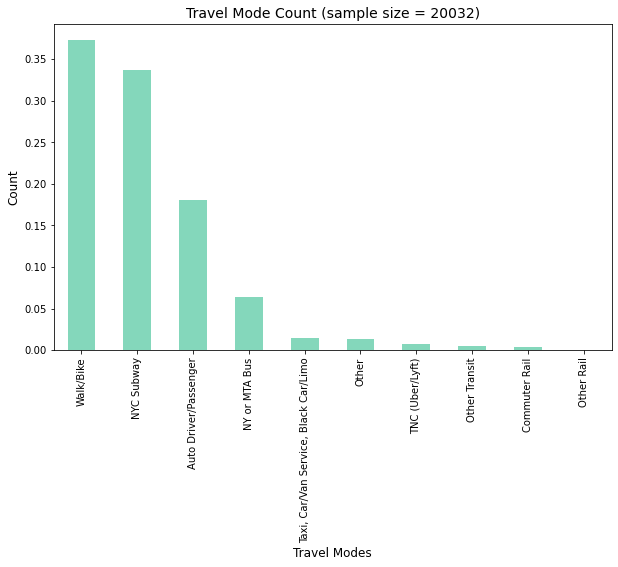

In [ ]:
# By plotting them we can again see that only the 4 label categories  are significant
modes_sorted.plot.bar(figsize = (10, 6), x = 'preferred mode', y = 'proportion', color = 'mediumaquamarine', alpha = 0.8, legend = False)
plt.xlabel('Travel Modes', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 90)
plt.title('Travel Mode Count (sample size = 20032)', fontsize = 14)

In [ ]:
# Mark all the less frequent categories as "Other"
df_personid = df_personid.reset_index()
travel_mode = ['Taxi, Car/Van Service, Black Car/Limo', 'TNC (Uber/Lyft)', 'Other Transit', 'Commuter Rail', 'Other Rail','Other']
for i in range(len(df_personid)):
    for j in travel_mode:
        if df_personid['preferred mode'][i] == j:
            df_personid['preferred mode'][i] = 'Other'

In [ ]:
# Find the updated distribution for the preferred modes of transportation 
modes = df_personid.reset_index()
modes = modes.groupby(['preferred mode']).agg({'personid':'count'}).reset_index()
modes.rename(columns = {'personid' : 'count'}, inplace = True)
modes['proportion'] = modes['count'] / modes['count'].sum()
modes_sorted = modes.sort_values('proportion', ascending = False)

Text(0.5, 1.0, 'Travel Mode Count (sample size = 20032)')

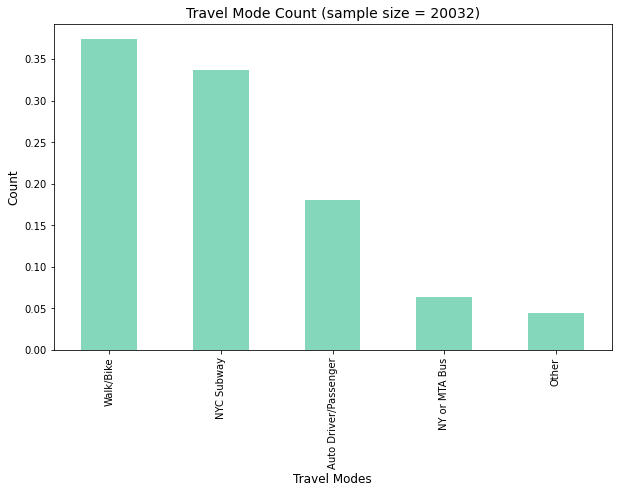

In [ ]:
# Plot it
modes_sorted.plot.bar(figsize = (10, 6), x = 'preferred mode', y = 'proportion', color = 'mediumaquamarine', alpha = 0.8, legend = False)
plt.xlabel('Travel Modes', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 90)
plt.title('Travel Mode Count (sample size = 20032)', fontsize = 14)

In [ ]:
# look at statistics for distance (for each personid)
df_personid['distance'].describe()

count    20022.000000
mean         5.879815
std         35.330552
min          0.000000
25%          0.621371
50%          2.019456
75%          4.660283
max       1790.169851
Name: distance, dtype: float64

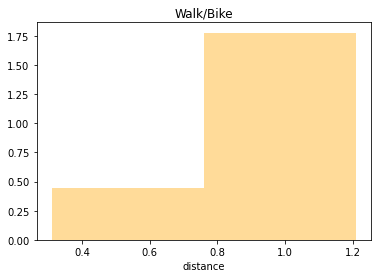

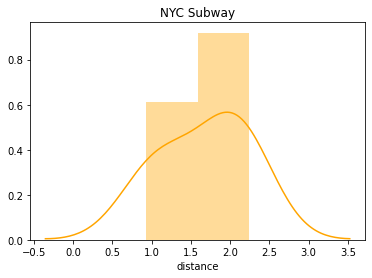

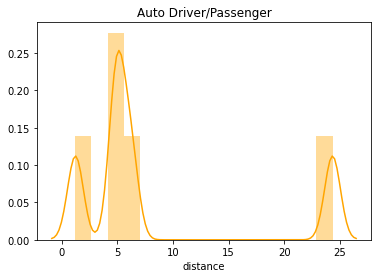

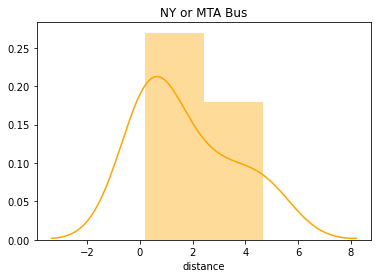

In [ ]:
# proportion of time/distance traveled with the top 4 modes
travel_mode = ['Walk/Bike', 'NYC Subway', 'Auto Driver/Passenger', 'NY or MTA Bus']
for i in travel_mode:
    mode = df_personid[df_personid['preferred mode'] == i]
    q = mode['distance'].quantile(0.99)
    temp = mode[mode['distance'] < q].head()
    fig, ax = plt.subplots()
    sns.distplot(temp['distance'], color = 'orange', ax = ax)
    plt.title(i)

Text(0.5, 1.0, 'Departure Hour Count (sample size = 20032)')

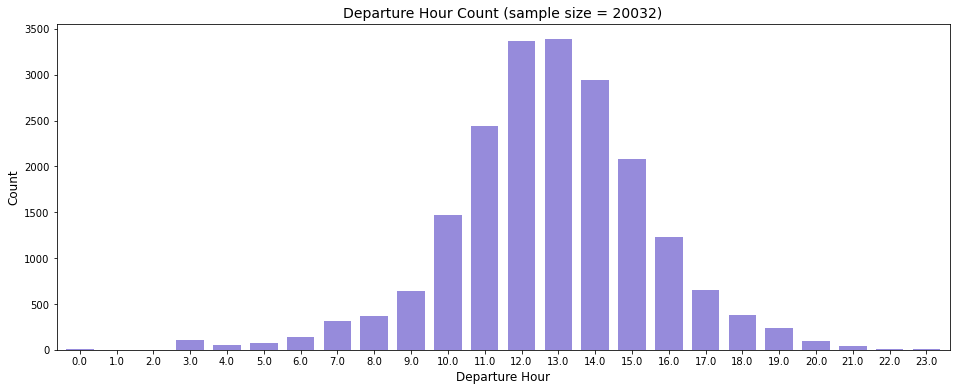

In [ ]:
# Departure hour count
df_personid['departure_hour'] = np.floor(df_personid['departure_hour'])
departure_hour = df_personid.groupby(['departure_hour']).agg({'sample_group':'count'}).reset_index()
departure_hour.plot.bar(figsize = (16, 6), x = 'departure_hour', y = 'sample_group', color = 'slateblue', alpha = 0.7, width = 0.75, legend = False)
plt.xlabel('Departure Hour', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 0)
plt.title('Departure Hour Count (sample size = 20032)', fontsize = 14)

Text(0.5, 1.0, 'Age Count (sample size = 20032)')

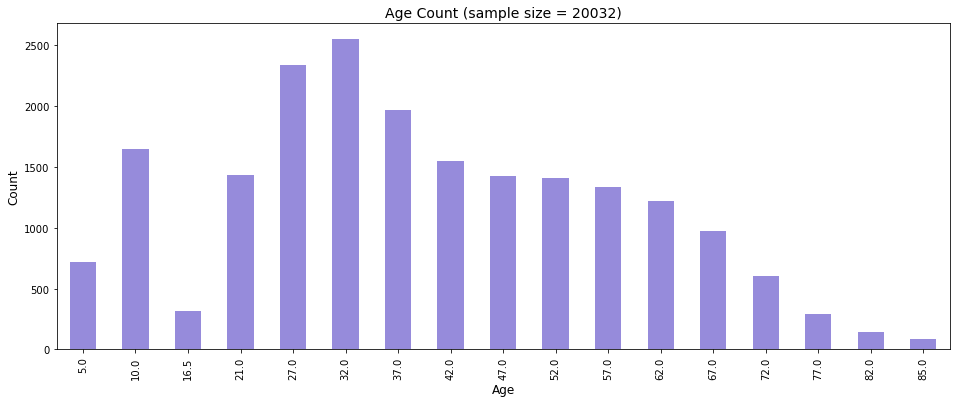

In [ ]:
# Age count
age = df_personid.groupby(['age']).agg({'personid':'count'}).reset_index()
age.plot.bar(figsize = (16, 6), x = 'age', y = 'personid', color = 'slateblue', alpha = 0.7, width = 0.5, legend = False)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 90)
plt.title('Age Count (sample size = 20032)', fontsize = 14)

Text(0.5, 1.0, 'Income Distribution (sample size = 20032)')

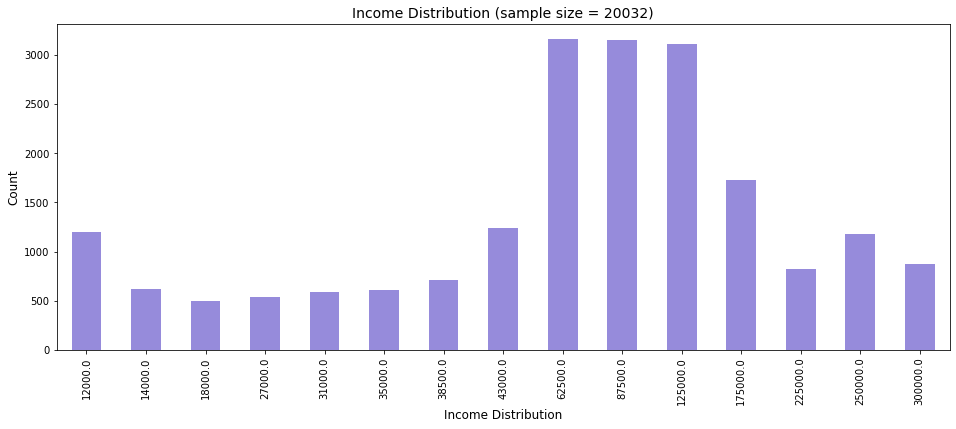

In [ ]:
# Income distribution
hhinc = df_personid.groupby(['hh_income']).agg({'personid':'count'}).reset_index()
hhinc.plot.bar(figsize = (16, 6), x = 'hh_income', y = 'personid', color = 'slateblue', alpha = 0.7, width = 0.5, legend = False)
plt.xlabel('Income Distribution', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 90)
plt.title('Income Distribution (sample size = 20032)', fontsize = 14)

Text(0.5, 1.0, 'Commute Frequency (sample size = 20032)')

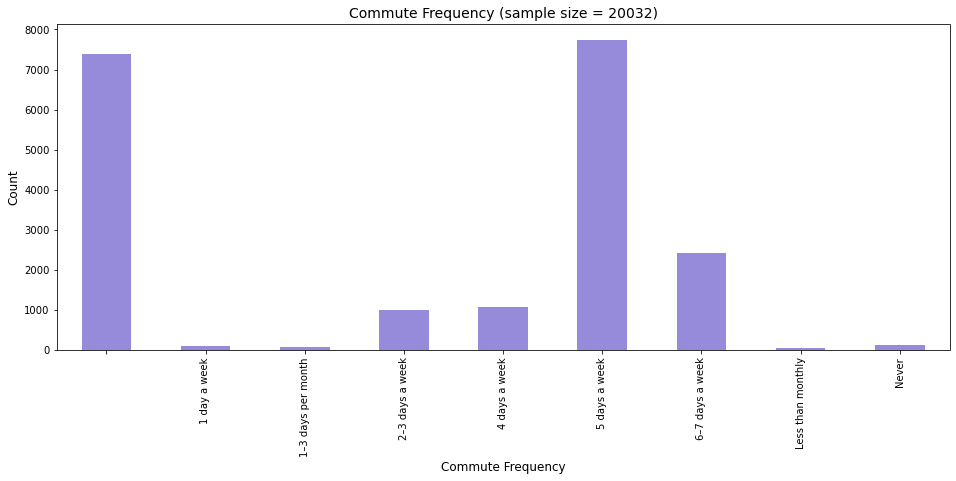

In [ ]:
# Commute frequency
comm_freq = df_personid.groupby(['commute_freq']).agg({'personid':'count'}).reset_index()
comm_freq.plot.bar(figsize = (16, 6), x = 'commute_freq', y = 'personid', color = 'slateblue', alpha = 0.7, width = 0.5, legend = False)
plt.xlabel('Commute Frequency', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.xticks(rotation = 90)
plt.title('Commute Frequency (sample size = 20032)', fontsize = 14)

### b. Zipcode Level

In [ ]:
# Shapefile for plotting on NYC map
zips = gpd.read_file('ZIP_CODE_040114.shp')
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips_sel = zips[['ZIPCODE', 'POPULATION', 'AREA', 'geometry']]
zips_sel.head()

,ZIPCODE,POPULATION,AREA,geometry
0,11436,18681.0,2.269930e+07,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,2.963100e+07,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,4.197210e+07,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,2.369863e+07,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,3.686880e+07,"POLYGON ((991997.113 176307.496, 992042.798 17..."


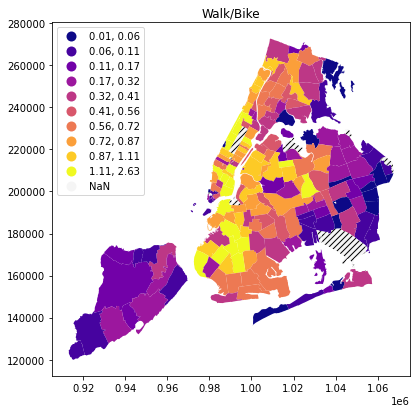

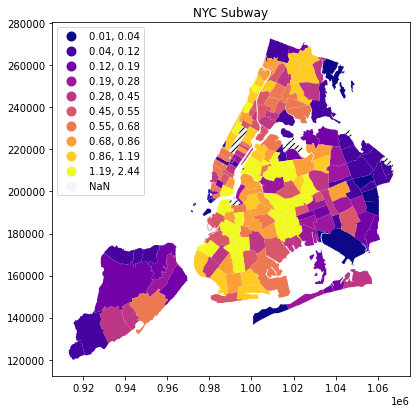

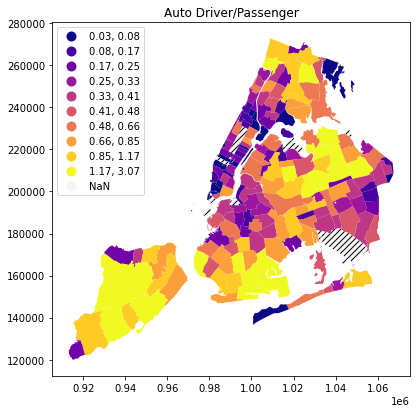

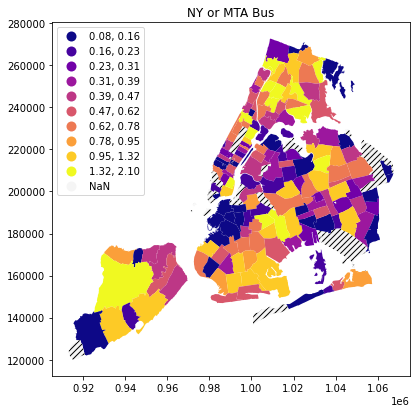

In [ ]:
# Plot modes proportion
travel_mode = ['Walk/Bike', 'NYC Subway', 'Auto Driver/Passenger', 'NY or MTA Bus']
for i in travel_mode:
    mode = df_personid[df_personid['preferred mode'] == i]
    mode_grp = mode.groupby(['home_postal_code']).agg({'preferred mode':'count'}).reset_index()
    mode_grp.rename(columns = {'preferred mode' : 'count'}, inplace = True)
    mode_grp['norm_count'] = 100*mode_grp['count'] /  mode_grp['count'].sum()
    mode_grp_zips = zips_sel.merge(mode_grp, left_on = 'ZIPCODE', right_on = 'home_postal_code', how = 'left')
    fig, ax = plt.subplots(figsize = (6.5,6.5))
    mode_grp_zips.plot(column = 'norm_count', cmap = 'plasma', k = 10, scheme = 'Quantiles', legend = True,
                    legend_kwds = {'loc': 'upper left'}, missing_kwds={'hatch':'////','color':'whitesmoke'}, ax = ax)
    plt.title(i)

## 3. Data Preprocessing

In [ ]:
# Here you can download the dataframe after processing
#df_personid.to_csv("df_personid.csv", index=True)
df_personid = pd.read_csv('df_personid.csv')
df_personid = df_personid.set_index("personid")
df_personid = df_personid.iloc[:,2:]
df_personid.head()

,hh_group,sample_group,dest_type,orig_type,tour_purpose,departure_hour,orig_bg,dest_bg,distance,vehicle_count,...,home_postal_code,preferred mode,ZIPCODE,comm_percent,mixed_percent,res_percent,bus,subway,citybike,norm_car_ev_count
personid,,,,,,,,,,,,,,,,,,,,,
2201,rMove,Postcard,Home,Home,Work,13.0,3.608100e+11,3.608100e+11,1.210038,0,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
5302,rSurvey,Postcard,Home,Home,K-12 School or daycare,12.0,3.608102e+11,3.608102e+11,0.310686,1,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
8801,rSurvey,MTA email list,Home,Home,K-12 School or daycare,11.0,3.608100e+11,3.608100e+11,0.932056,0,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
8802,rSurvey,MTA email list,Home,Home,K-12 School or daycare,11.0,3.608100e+11,3.608100e+11,0.932056,0,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
8803,rSurvey,MTA email list,Home,Home,K-12 School or daycare,11.0,3.608100e+11,3.608100e+11,0.932056,0,...,11101.0,Walk/Bike,11101,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336


In [ ]:
# drop columns that are not useful for prediction
df_personid = df_personid.drop(columns=["dest_bg","orig_bg","home_postal_code"])

In [ ]:
# Manually encode household group
df_personid["hh_group"] = df_personid["hh_group"].replace(["rSurvey","rMove"],[0,1],)

In [ ]:
# Make sure categorical data is in string format
cat = ["sample_group","dest_type","orig_type","tour_purpose","res_duration",\
                            "education_level","english_prof","job_type","hours_worked","commute_freq",\
                            "telecommute_freq"]
for i in cat:
    df_personid[i] = df_personid[i].astype(str)

In [ ]:
nas = pd.DataFrame(df_personid.isna().sum())
print(nas.to_string())

                            0
hh_group                    0
sample_group                0
dest_type                   0
orig_type                   0
tour_purpose                0
departure_hour              0
distance                    0
vehicle_count               0
hhsize                      0
res_duration                0
home_bg                     0
hh_income                   0
gender                      0
age                         0
job_count                   0
education_level             0
english_prof                0
ethnicity_american_alaska   0
ethnicity_asian             0
ethnicity_black             0
ethnicity_hawaii            0
ethnicity_white             0
ethnicity_other             0
ethnicity_noanswer          0
job_type                    0
hours_worked                0
commute_freq                0
telecommute_freq            0
is_student                  0
has_license                 0
hasunder18                  0
hassmartphone               0
isbornus  

In [ ]:
df_personid = df_personid.drop(columns=['orig_type','education_level','job_type','commute_freq','telecommute_freq'])
df_personid = df_personid.dropna()
df_personid.shape

(20005, 38)

In [ ]:
encoder = OrdinalEncoder()
df_personid['preferred mode'] = encoder.fit_transform(df_personid['preferred mode'], axis=1)

In [ ]:
y = df_personid['preferred mode']

In [ ]:
df_personid = df_personid.select_dtypes(exclude=['object'])
x = df_personid.drop(['preferred mode','home_bg','ZIPCODE', 'comm_percent', 'mixed_percent',
       'res_percent', 'bus', 'subway', 'citybike', 'norm_car_ev_count'], axis=1)
x = x.dropna()
x.shape

(20005, 21)

In [ ]:
x.head()

,hh_group,departure_hour,distance,vehicle_count,hhsize,hh_income,age,job_count,ethnicity_american_alaska,ethnicity_asian,...,ethnicity_hawaii,ethnicity_white,ethnicity_other,ethnicity_noanswer,is_student,has_license,hasunder18,hassmartphone,isbornus,num_trips
personid,,,,,,,,,,,,,,,,,,,,,
2201,1,13.0,1.210038,0,3,300000.0,37.0,1,0,0,...,0,1,0,0,0,1,1,1,1,23
5302,0,12.0,0.310686,1,2,125000.0,32.0,0,0,0,...,0,1,0,0,1,1,0,1,1,2
8801,0,11.0,0.932056,0,3,38500.0,32.0,1,0,0,...,0,1,0,0,0,1,1,1,1,4
8802,0,11.0,0.932056,0,3,38500.0,10.0,0,0,0,...,0,0,0,0,1,0,1,0,0,4
8803,0,11.0,0.932056,0,3,38500.0,10.0,0,0,0,...,0,0,0,0,1,0,1,0,0,4


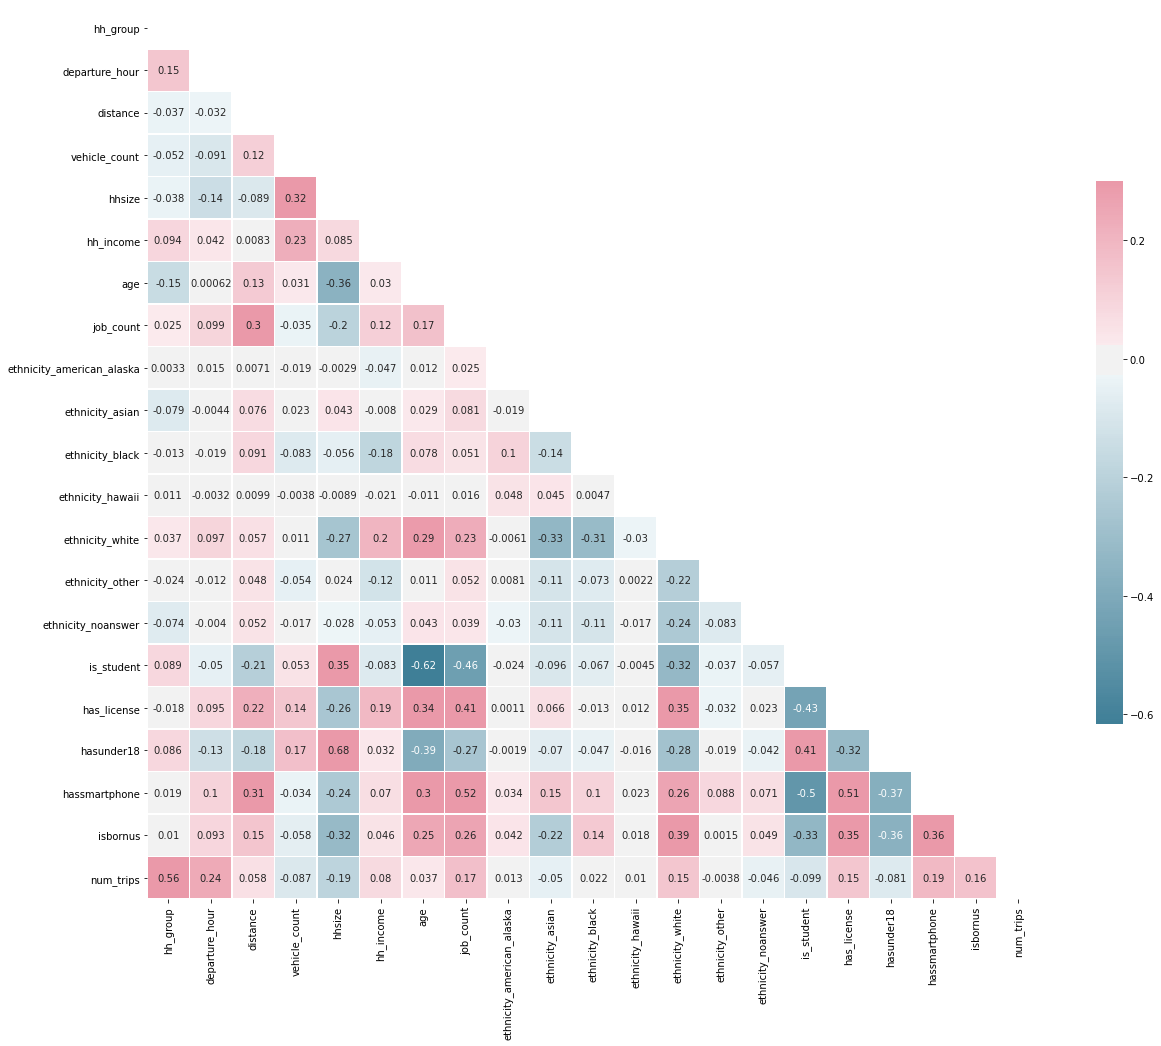

In [ ]:
# Correlation heat map
corr = x.corr(method ='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(225, 5, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [ ]:
# pair = x[['distance', 'age', 'hh_income']]
# sns.pairplot(pair)

In [ ]:
# # Select top 10 features
# features_norm = MinMaxScaler().fit_transform(x)
# chi_selector = SelectKBest(chi2, k=10)
# chi_selector.fit(features_norm, y)

# chi_support = chi_selector.get_support()
# chi_feature = x.loc[:,chi_support].columns.tolist()
# print(str(len(chi_feature)), 'selected features')
# print('Top-10 features: \n', chi_feature)

In [ ]:
# x_10 = x[['hh_group', 'vehicle_count', 'ethnicity_asian', 'ethnicity_black', 'ethnicity_white', 'ethnicity_other', 'is_student', 'has_license', 'hasunder18', 'hassmartphone']]
# x_10.head()

## 4. Data Modeling (Classification)

### a. Benchmark

#### I. Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)

pipeline = Pipeline([('classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000))])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
print(f'Test score: {grid_search.score(X_test, y_test)}')
acc_lr = np.round(grid_search.score(X_test, y_test),4)
print(grid_search.best_params_)
y_pred = grid_search.predict(X_test)

Test score: 0.4066949409269918
{'classifier__C': 0.1}


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.42      0.93      0.58      2640
           2       0.32      0.12      0.18      1771
           3       0.00      0.00      0.00       674
           4       0.38      0.01      0.02       293
           5       0.28      0.01      0.02      1224

    accuracy                           0.41      6602
   macro avg       0.28      0.21      0.16      6602
weighted avg       0.32      0.41      0.28      6602



#### II. Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)
gnb = GaussianNB().fit(X_train, y_train)
print(f'In sample prediction accuracy: {gnb.score(X_train,y_train)}')
print(f'Out of sample prediction accuracy: {gnb.score(X_test,y_test)}')
acc_nb = np.round(gnb.score(X_test,y_test),4)
y_pred = gnb.predict(X_test)

In sample prediction accuracy: 0.34350518540625236
Out of sample prediction accuracy: 0.3436837322023629


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.25      0.34      2640
           2       0.30      0.88      0.45      1771
           3       0.20      0.01      0.01       674
           4       0.39      0.06      0.11       293
           5       0.38      0.01      0.03      1224

    accuracy                           0.34      6602
   macro avg       0.36      0.24      0.19      6602
weighted avg       0.40      0.34      0.27      6602



#### III. Decision Tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)
param_grid = {'max_depth': range(2, 100, 10),
              'min_samples_split':  range(2, 10, 1),
              'max_leaf_nodes': range(2, 20, 2)
              }

dt = DecisionTreeClassifier()
gr = GridSearchCV(dt, param_grid = param_grid)
rs = gr.fit(X_train, y_train)
print(rs.best_params_)

# in sample accuracy
print('In sample accuracy:', rs.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:', rs.score(X_test, y_test))
acc_dt = np.round(rs.score(X_test,y_test),4)
y_pred = rs.predict(X_test)

{'max_depth': 12, 'max_leaf_nodes': 18, 'min_samples_split': 4}
In sample accuracy: 0.562411400432739
Out of sample accuracy: 0.540896697970312


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.68      0.66      2640
           2       0.48      0.57      0.52      1771
           3       0.00      0.00      0.00       674
           4       0.23      0.04      0.07       293
           5       0.46      0.62      0.53      1224

    accuracy                           0.54      6602
   macro avg       0.36      0.38      0.36      6602
weighted avg       0.48      0.54      0.50      6602



#### IV. SVM

In [ ]:
X_scaled = preprocessing.scale(x)

param_grid ={'kernel':['rbf', 'poly'],
            'C': 10**np.linspace(-5,10,20),
             'degree': range(1,7),
            'max_iter':[200]
             }

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y.copy().to_frame(), test_size=0.33, random_state=111)
clf = svm.SVC()
gr = GridSearchCV(clf, param_grid=param_grid)
rs = gr.fit(X_train, Y_train)

# Report IS and OS results.
y_pred = rs.predict(X_train)
y_os_pred = rs.predict(X_test)
print(rs.best_params_)
print('In sample accuracy:',accuracy_score(Y_train,y_pred))
print('Out of sample accuracy:',accuracy_score(Y_test,y_os_pred))
acc_svm = np.round(rs.score(X_test,y_os_pred),4)
y_pred = rs.predict(X_test)

{'C': 0.5455594781168515, 'degree': 1, 'kernel': 'rbf', 'max_iter': 200}
In sample accuracy: 0.3837946728344401
Out of sample accuracy: 0.3865495304453196


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.45      0.62      0.52      2640
           2       0.37      0.20      0.26      1771
           3       0.11      0.00      0.01       674
           4       0.67      0.01      0.01       293
           5       0.29      0.46      0.35      1224

    accuracy                           0.39      6602
   macro avg       0.38      0.26      0.23      6602
weighted avg       0.37      0.39      0.34      6602



#### V. Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x.copy(), y.copy(), test_size=0.33, random_state=111)

param_grid = { 
    'n_estimators': np.arange(1,50,5),
    'max_depth' : np.arange(1,10,1),
    'max_features' : np.arange(1,14,1)
}

rf = RandomForestClassifier(n_jobs = -1, max_leaf_nodes = 10)
gr = GridSearchCV(rf, param_grid = param_grid)
rs = gr.fit(X_train, y_train)
print(rs.best_params_)
    
# in sample accuracy
print('In sample accuracy:', rs.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:', rs.score(X_test, y_test))
acc_rf = np.round(rs.score(X_test,y_test),4)
y_pred = rs.predict(X_test)

{'max_depth': 4, 'max_features': 13, 'n_estimators': 21}
In sample accuracy: 0.5639036036708199
Out of sample accuracy: 0.5474098757952136


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.75      0.67      2640
           2       0.49      0.56      0.52      1771
           3       0.00      0.00      0.00       674
           4       0.00      0.00      0.00       293
           5       0.48      0.53      0.50      1224

    accuracy                           0.55      6602
   macro avg       0.32      0.37      0.34      6602
weighted avg       0.46      0.55      0.50      6602



### b. Added Spatial Variables

In [ ]:
x_s = df_personid.drop(['preferred mode','home_bg','ZIPCODE'], axis=1)
x_s = x_s.dropna()
x_s.head()

,hh_group,departure_hour,distance,vehicle_count,hhsize,hh_income,age,job_count,ethnicity_american_alaska,ethnicity_asian,...,hassmartphone,isbornus,num_trips,comm_percent,mixed_percent,res_percent,bus,subway,citybike,norm_car_ev_count
personid,,,,,,,,,,,,,,,,,,,,,
2201,1,13.0,1.210038,0,3,300000.0,37.0,1,0,0,...,1,1,23,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
5302,0,12.0,0.310686,1,2,125000.0,32.0,0,0,0,...,1,1,2,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
8801,0,11.0,0.932056,0,3,38500.0,32.0,1,0,0,...,1,1,4,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
8802,0,11.0,0.932056,0,3,38500.0,10.0,0,0,0,...,0,0,4,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336
8803,0,11.0,0.932056,0,3,38500.0,10.0,0,0,0,...,0,0,4,0.085527,0.041913,0.05536,181.0,12.0,13.0,0.544336


In [ ]:
x_s["norm_car_ev_count"] = x_s["norm_car_ev_count"].replace([np.inf, np.nan], [0.0,0.0])

#### I. Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_s.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)

pipeline = Pipeline([('classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000))])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
print(f'Test score: {grid_search.score(X_test, y_test)}')
acc_lr = np.round(grid_search.score(X_test, y_test),4)
print(grid_search.best_params_)
y_pred = grid_search.predict(X_test)

Test score: 0.4365343835201454
{'classifier__C': 1000}


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.85      0.60      2640
           2       0.36      0.24      0.29      1771
           3       0.00      0.00      0.00       674
           4       1.00      0.00      0.01       293
           5       0.38      0.17      0.23      1224

    accuracy                           0.44      6602
   macro avg       0.44      0.25      0.22      6602
weighted avg       0.40      0.44      0.36      6602



#### II. Naive Bayes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_s.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)
gnb = GaussianNB().fit(X_train, y_train)
print(f'In sample prediction accuracy: {gnb.score(X_train,y_train)}')
print(f'Out of sample prediction accuracy: {gnb.score(X_test,y_test)}')
acc_nb_spatial = np.round(gnb.score(X_test,y_test),4)
y_pred = gnb.predict(X_test)

In sample prediction accuracy: 0.3815563679773185
Out of sample prediction accuracy: 0.38336867615873976


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.58      0.30      0.39      2640
           2       0.32      0.81      0.46      1771
           3       0.26      0.01      0.02       674
           4       0.40      0.06      0.11       293
           5       0.44      0.23      0.30      1224

    accuracy                           0.38      6602
   macro avg       0.40      0.28      0.26      6602
weighted avg       0.44      0.38      0.34      6602



#### III. Decision Tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_s.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)
param_grid = {'max_depth': range(2, 100, 10),
              'min_samples_split':  range(2, 10, 1),
              'max_leaf_nodes': range(2, 20, 2)
              }

dt = DecisionTreeClassifier()
gr = GridSearchCV(dt, param_grid = param_grid)
rs = gr.fit(X_train, y_train)
print(rs.best_params_)

# in sample accuracy
print('In sample accuracy:', rs.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:', rs.score(X_test, y_test))
acc_dt_spatial = np.round(rs.score(X_test,y_test),4)
y_pred = rs.predict(X_test)

{'max_depth': 12, 'max_leaf_nodes': 18, 'min_samples_split': 2}
In sample accuracy: 0.5601730955756175
Out of sample accuracy: 0.5387761284459255


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.68      0.65      2640
           2       0.50      0.55      0.52      1771
           3       0.00      0.00      0.00       674
           4       0.23      0.04      0.07       293
           5       0.45      0.64      0.53      1224

    accuracy                           0.54      6602
   macro avg       0.36      0.38      0.35      6602
weighted avg       0.48      0.54      0.50      6602



#### IV. SVM

In [ ]:
x_s_scaled = preprocessing.scale(x_s)
X_train, X_test, y_train, y_test = train_test_split(x_s_scaled.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)

param_grid ={'kernel':['rbf', 'poly'],
            'C': 10**np.linspace(-5,10,20),
             'degree': range(1,7),
            'max_iter':[200]
             }

clf = svm.SVC()
gr = GridSearchCV(clf, param_grid=param_grid)
rs = gr.fit(X_train, y_train)

# Report IS and OS results.
y_pred = rs.predict(X_train)
y_os_pred = rs.predict(X_test)
print(rs.best_params_)
print('In sample accuracy:',accuracy_score(y_train,y_pred))
print('Out of sample accuracy:',accuracy_score(y_test,y_os_pred))
acc_svm_spatial = np.round(rs.score(X_test,y_os_pred),4)
y_pred = rs.predict(X_test)

{'C': 0.5455594781168515, 'degree': 1, 'kernel': 'rbf', 'max_iter': 200}
In sample accuracy: 0.41550399164366186
Out of sample accuracy: 0.3959406240533172


In [ ]:
# micro averages
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.46      0.65      0.54      2640
           2       0.35      0.20      0.25      1771
           3       0.18      0.09      0.12       674
           4       0.12      0.03      0.04       293
           5       0.33      0.39      0.36      1224

    accuracy                           0.40      6602
   macro avg       0.29      0.27      0.26      6602
weighted avg       0.36      0.40      0.36      6602



#### V. Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_s.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)
param_grid = { 
    'n_estimators': np.arange(1,50,5),
    'max_depth' : np.arange(1,10,1),
    'max_features' : np.arange(1,14,1)
}

rf = RandomForestClassifier(n_jobs = -1, max_leaf_nodes = 10)
gr = GridSearchCV(rf, param_grid = param_grid)
rs = gr.fit(X_train, y_train)
print(rs.best_params_)
    
# in sample accuracy
print('In sample accuracy:', rs.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:', rs.score(X_test, y_test))
acc_rf_spatial = np.round(rs.score(X_test,y_test),4)
y_pred = rs.predict(X_test)

{'max_depth': 5, 'max_features': 10, 'n_estimators': 41}
In sample accuracy: 0.565395806908901
Out of sample accuracy: 0.5492275068161163


In [ ]:
# micro averages (for the best model)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.74      0.67      2640
           2       0.49      0.62      0.55      1771
           3       0.00      0.00      0.00       674
           4       0.00      0.00      0.00       293
           5       0.50      0.47      0.48      1224

    accuracy                           0.55      6602
   macro avg       0.32      0.37      0.34      6602
weighted avg       0.47      0.55      0.50      6602



### c. Handling Imbalanced Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_s.copy(), y.copy().to_frame(), test_size=0.33,random_state=111)
pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                ['classifier', RandomForestClassifier(n_jobs = -1, max_leaf_nodes = 10)]])


stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = { 
    'classifier__n_estimators': np.arange(1,50,5),
    'classifier__max_depth' : np.arange(1,10,1),
    'classifier__max_features' : np.arange(1,14,1)
}

rs = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           n_jobs=-1)

rs.fit(X_train, y_train)
print(rs.best_params_)
# in sample accuracy
print('In sample accuracy:', rs.score(X_train, y_train))
# out of sample accuracy
print('Out of sample accuracy:', rs.score(X_test, y_test))
acc_rf_spatial_smote = np.round(rs.score(X_test,y_test),4)
y_pred = rs.predict(X_test)

{'classifier__max_depth': 3, 'classifier__max_features': 3, 'classifier__n_estimators': 31}
In sample accuracy: 0.48906961128105647
Out of sample accuracy: 0.46758558012723417


In [ ]:
# Now metrics are more balanced between different sized classes but overall performance has dropped
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.65      0.55      0.60      2640
           2       0.53      0.26      0.35      1771
           3       0.22      0.19      0.20       674
           4       0.12      0.19      0.15       293
           5       0.41      0.81      0.54      1224

    accuracy                           0.47      6602
   macro avg       0.39      0.40      0.37      6602
weighted avg       0.51      0.47      0.46      6602



## 5. Results Overview

In [ ]:
# Results before using SMOTE
d = {'With Spatial Variable': ['No', 'Yes'], 'Logistic Regression': [acc_lr, acc_lr_spatial], 'Naive Bayes': [acc_nb,acc_nb_spatial], 'SVM':[acc_svm,acc_svm_spatial],'Decision Tree':[acc_dt,acc_dt_spatial],'Random Forest':[acc_rf,acc_rf_spatial]}
df = pd.DataFrame(data=d)
df

,With Spatial Variable,Logistic Regression,Naive Bayes,SVM,Decision Tree,Random Forest
0,No,0.4067,0.3437,0.3865,0.5409,0.5474
1,Yes,0.4365,0.3834,0.3960,0.5388,0.5492


In [ ]:
change = (acc_rf_spatial_smote - acc_rf_spatial)/acc_rf_spatial_smote*100
change = float("{:.4f}".format(change))
print("The best model was the Random Forest with spatial variables which had an accuracy of {}. By using SMOTE to balance labels we reach an accuracy of {}, with a variation in accuracy of {}% with respect to the original model".format(acc_rf_spatial,acc_rf_spatial_smote,change))

The best model was the Decision Tree with max_depth = 8 without spatial variables which had an accuracy of 0.5492. By using SMOTE to balance labels we reach an accuracy of 0.4676, with a variation in accuracy of -17.4508% with respect to the original model
